In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
import GPy

In [2]:
os.chdir('/home/saumya/Documents/FINAL_DATA_FINAL/Spec')

In [3]:
x_dat = np.load('ABS_noisy_SNR_new.npy')
# x_dat = np.reshape(x_dat, -1)[:, None]

In [4]:
x_dat.shape

(5250, 3000)

In [5]:
x_dat

array([[ 8.1122e-05,  3.8922e-05,  3.0088e-04, ...,  1.8597e-04,
         3.8815e-04,  3.9840e-04],
       [ 1.8311e-04,  1.3924e-04,  5.5134e-05, ...,  4.8876e-04,
         3.0565e-04,  3.2973e-04],
       [ 9.8586e-05,  2.2447e-04,  3.7432e-05, ...,  4.4417e-04,
         6.7234e-04,  1.1837e-04],
       ...,
       [ 1.2817e-03,  1.1425e-03, -2.2423e-04, ...,  3.1528e-03,
         2.0695e-03,  2.2812e-03],
       [ 1.8377e-03,  3.2349e-03,  2.9545e-03, ...,  3.9520e-03,
         2.8610e-03,  4.5738e-03],
       [ 2.7771e-03,  6.2847e-04, -7.3099e-04, ...,  1.0796e-03,
         3.5896e-03,  3.0384e-03]], dtype=float16)

In [6]:
os.chdir('/home/saumya/Documents/FINAL_DATA_FINAL/Param_profile')

In [7]:
y_dat_std = np.load('final_param_FINAL.npy')

# y_dat = np.reshape(y_dat, -1)[:, None]

# y_dat = y_dat[:10000]

In [8]:
os.chdir('/home/saumya/Documents/FINAL_DATA_FINAL/Model_data_noisy/LMC')

In [9]:
y_A1_T = StandardScaler().fit(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_T = StandardScaler().fit(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_T = StandardScaler().fit(np.reshape(y_dat_std[:,2],-1)[:,None])

In [10]:
y_A1_d = y_A1_T.transform(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_d = y_A2_T.transform(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_d = y_A3_T.transform(np.reshape(y_dat_std[:,2],-1)[:,None])

In [11]:
import pickle


with open('LMC_A1.pkl', 'wb') as file:
    pickle.dump(y_A1_T, file)

with open('LMC_A2.pkl', 'wb') as file:
    pickle.dump(y_A2_T, file)

with open('LMC_A3.pkl', 'wb') as file:
    pickle.dump(y_A3_T, file)

In [12]:
y_dat = np.column_stack((y_A1_d, y_A2_d, y_A3_d))

In [13]:
# import pickle

# import pickle
# with open('y_d_T_ICM.pkl', 'wb') as file:
#     pickle.dump(y_dat_transform, file)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def train_val_test_split(X, y, val_size):
    # test_size = 1 - train_size - val_size
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = val_size)
    # relative_train_size = train_size / (val_size + train_size)
    # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    #   train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train_val, X_test, y_train_val, y_test

In [16]:
X_train, X_test, Y_train, Y_test = train_val_test_split(x_dat, y_dat, .2)

In [17]:
(y_dat[2][0])

-1.6201851746019653

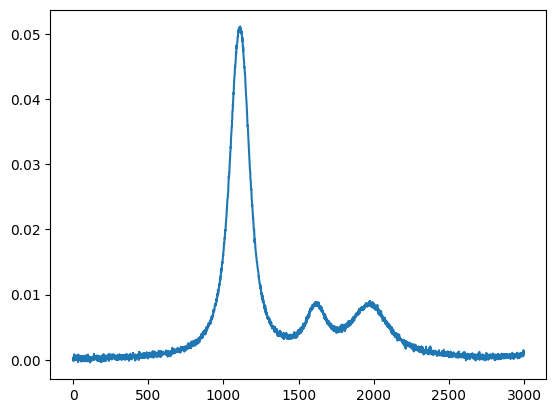

In [18]:
plt.plot(x_dat[1200])

In [19]:
max(x_dat[1200])

0.05112

In [20]:
# LMC set up
ks = [GPy.kern.RBF(np.shape(X_train)[1]) for i in range(1)]
icm = GPy.util.multioutput.LCM(input_dim=np.shape(X_train)[1],num_outputs=1,kernels_list=ks)

In [21]:
print(icm)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)

  ICM0.            |         value  |  constraints  |  priors
  rbf.variance     |           1.0  |      +ve      |        
  rbf.lengthscale  |           1.0  |      +ve      |        
  B.W              |  [0.02347566]  |               |        
  B.kappa          |           0.5  |      +ve      |        


In [22]:
Y_train.shape

(4200, 3)

In [23]:
m = GPy.models.GPCoregionalizedRegression([X_train],[Y_train],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 15369.581322030488
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |         value  |  constraints  |  priors
  ICM0.rbf.variance                      |           1.0  |   +ve fixed   |        
  ICM0.rbf.lengthscale                   |           1.0  |      +ve      |        
  ICM0.B.W                               |  [0.02347566]  |               |        
  ICM0.B.kappa                           |           0.5  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |           1.0  |      +ve      |        


In [24]:
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)

In [25]:
m.optimize(messages=True)

In [26]:
with open('gpr_LMC_Norm.pkl', 'wb') as file:
    pickle.dump(m, file)

In [27]:
print(m)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)


Name : gp
Objective : 12521.077467156803
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM0.rbf.variance                      |                  1.0  |   +ve fixed   |        
  ICM0.rbf.lengthscale                   |  0.14277559260121778  |      +ve      |        
  ICM0.B.W                               |         [0.61000363]  |               |        
  ICM0.B.kappa                           |   1.7823047258694413  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   0.3252894404215673  |      +ve      |        


In [28]:
newX = X_test

In [29]:
newX = np.concatenate((newX,np.zeros((np.shape(X_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys_norm,var=m.predict(newX,Y_metadata=noise_dict)

# Temper_test_=scalerT.inverse_transform(ys)


In [30]:
ys_norm[:,0]

array([ 1.36244408,  1.60371234, -1.46161944, ..., -0.97154865,
        0.45305769,  0.50953585])

In [31]:
Y_test[:,0]

array([ 1.62018517,  1.62018517, -1.38873015, ..., -0.9258201 ,
        0.23145502,  0.69436507])

In [32]:
ys = np.zeros_like(ys_norm)
Y_test_real = np.zeros_like(Y_test)

In [33]:
ys[:, 0] = y_A1_T.inverse_transform(ys_norm[:,0].reshape(-1,1)).ravel()
ys[:, 1] = y_A2_T.inverse_transform(ys_norm[:,1].reshape(-1,1)).ravel()
ys[:, 2] = y_A3_T.inverse_transform(ys_norm[:,2].reshape(-1,1)).ravel()

In [34]:
Y_test_real[:, 0] = y_A1_T.inverse_transform(Y_test[:,0].reshape(-1,1)).ravel()
Y_test_real[:, 1] = y_A2_T.inverse_transform(Y_test[:,1].reshape(-1,1)).ravel()
Y_test_real[:, 2] = y_A3_T.inverse_transform(Y_test[:,2].reshape(-1,1)).ravel()

In [35]:
ys[:,0]-Y_test_real[:,0]

array([-37.38409609,  -2.38930469, -10.57223835, ...,  -6.63270433,
        32.14239124, -26.80858196])

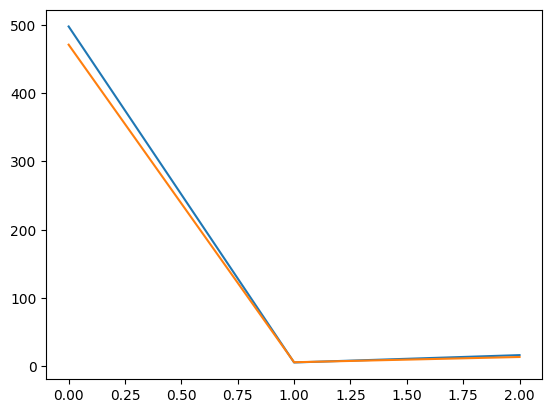

In [36]:
plt.plot(ys[1000])

plt.plot(Y_test_real[1000])

In [37]:
ys-Y_test_real

array([[-37.38409609,  -2.06920809,   2.75772788],
       [ -2.38930469,   1.63163417,  -2.41372304],
       [-10.57223835,   0.32554146,  15.97107304],
       ...,
       [ -6.63270433,  -0.69806806,  -6.78781765],
       [ 32.14239124,   0.31451589,  -2.31500819],
       [-26.80858196,  -2.50751299,   4.21794777]])

In [38]:
Y_test_real

array([[773.        ,   8.        ,  37.52941176],
       [773.        ,   1.        ,  48.64705882],
       [336.57142857,   5.        ,   2.58823529],
       ...,
       [403.71428571,   7.        ,  53.41176471],
       [571.57142857,   5.        ,  12.11764706],
       [638.71428571,   9.        ,  26.41176471]])

In [39]:
from sklearn import metrics

In [40]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 1]), np.array(Y_test_real[:, 1]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 5.897811213767857


In [41]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 2]), np.array(Y_test_real[:, 2]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 51.41953022007185


In [42]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 0]), np.array(Y_test_real[:, 0]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 2029.378852028829


In [43]:
metrics.mean_squared_error(ys, Y_test_real)

695.5653978208899

In [44]:
np.save("true_vals_lmc", Y_test_real)

In [45]:
np.save("pred_vals_lmc", ys)
